# Litecoin Price Prediction 2021

## 1. Data Preparation

In [172]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, classification_report,accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional, Input, GRU
from keras.models import Sequential,Model
from keras.regularizers import l2

In [173]:
df = pd.read_csv('data/coin_Litecoin.csv')

#spliting 'Date' column to 'date' and 'time'
df['Date'] = pd.to_datetime(df['Date'])
df['date'] = df['Date'].dt.date
df['time'] = df['Date'].dt.time

#drop non-relevant columns
df.drop(['SNo','Name','Symbol','Date','time'], axis=1, inplace=True,errors='ignore')
#set date as new index
df.set_index('date',inplace=True)

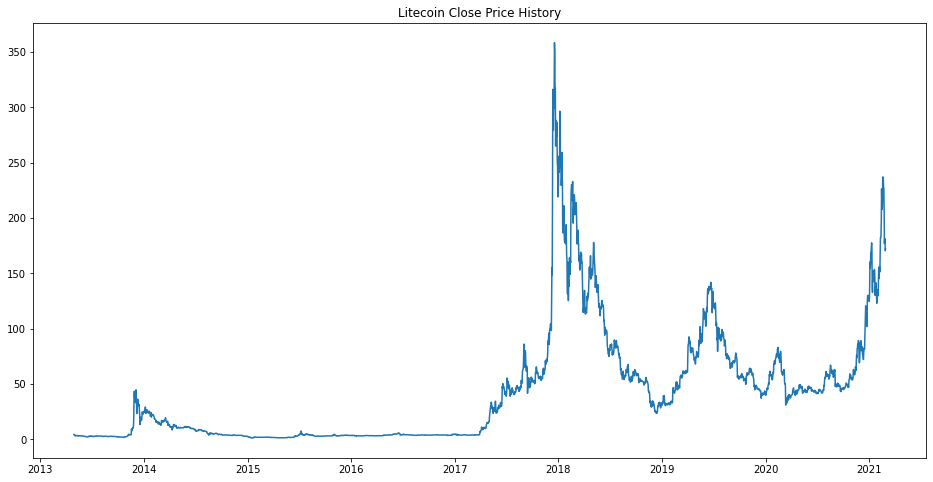

In [174]:
plt.figure(figsize=(16,8))
plt.title('Litecoin Close Price History')
plt.plot(df['Close'])

# Using 1 input for LSTM model

## 2.Data Preprocessing

In [175]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.85)]
test_df = df[int(n*0.85):]

num_features = df.shape[1]

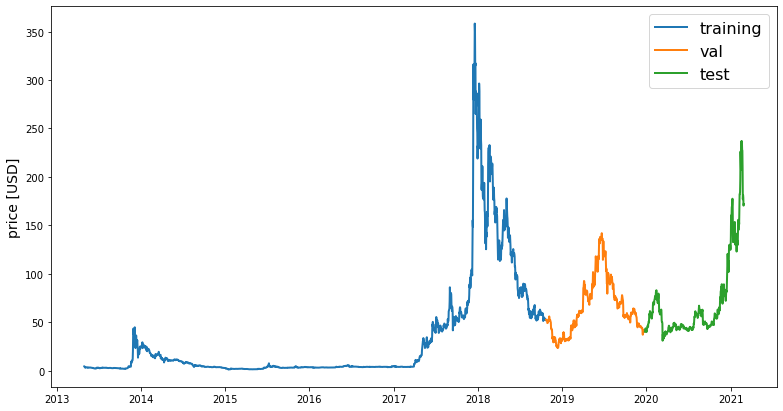

In [176]:
def line_plot2(line1, line2,label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

def line_plot3(line1, line2,line3, label1=None, label2=None,label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)


line_plot3(line1 = train_df.filter(['Close']), 
          line2 = val_df.filter(['Close']),
          line3 = test_df.filter(['Close']), label1='training',label2='val',label3= 'test', title='')

### 2.1 Data Normalization

In [177]:
def scale_func(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_data = pd.DataFrame(scaled_data,index=df.index, columns=df.columns)
    return scaled_data, scaler

scaled_train_df, scaler  = scale_func(df) 

In [178]:
#create the training data set
def generate_input(df, window, target):
    #create the scaled training data set
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(window, len(df)):
        x_train.append(df.iloc[i-window:i, :][target])
        y_train.append(df.iloc[i,:,][target])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train

In [179]:
x_train, y_train = generate_input(scaled_train_df,15, "Close")
print("Training set:",x_train.shape)

Training set: (2847, 15, 1)


In [180]:
def model_base_build(input_shape):
    #build the lstm model
    model = Sequential()
    model.add(LSTM(100, return_sequences=True,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), input_shape = input_shape))
    model.add(LSTM(100, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1))
    model.add(Activation('linear'))
    #compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def model_class_build(input_shape):
    #build the lstm model
    model = Sequential()
    #### Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.2))
    #### Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    #### Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    #### Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    #### Adding the output layer
    model.add(Dense(units = 1))
    model.add(Activation('linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def model_GRU_build(input_shape):
    model = Sequential()
    # Input layer
    model.add(GRU(120,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.4)) 
    # Hidden layer
    model.add(GRU(120)) 
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model



def biLSTM_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(210,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), return_sequences=True, input_shape = (x_train.shape[1],1))))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(210)))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
def accuracy_forecast(target_val ,prediction_val):   
    bi_targ = np.sign(target_val.rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]))[1:].values
    bi_pred = np.sign(prediction_val.rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]))[1:].values
    return accuracy_score(bi_targ,bi_pred)

In [181]:
LSTM1 = model_base_build(input_shape= (x_train.shape[1],x_train.shape[2]))
LSTM2 = model_class_build(input_shape= (x_train.shape[1],x_train.shape[2]))
GRU_model = model_GRU_build(input_shape= (x_train.shape[1],x_train.shape[2]))
biLSTM = biLSTM_model(input_shape= (x_train.shape[1],x_train.shape[2]))

In [182]:
#train the model
history1 = LSTM1.fit(x_train, y_train, batch_size=32, epochs=80)
history2 = LSTM2.fit(x_train, y_train, batch_size=32, epochs=80)
history3 = GRU_model.fit(x_train, y_train, batch_size=32, epochs=80)
history4 = biLSTM.fit(x_train, y_train, batch_size=32, epochs=80)

Epoch 1/80
89/89 [==============================] - 5s 16ms/step - loss: 1.5484: 0s 
Epoch 2/80
89/89 [==============================] - 2s 18ms/step - loss: 0.8284
Epoch 3/80
89/89 [==============================] - 2s 17ms/step - loss: 0.6578
Epoch 4/80
89/89 [==============================] - 2s 18ms/step - loss: 0.5345
Epoch 5/80
89/89 [==============================] - 2s 17ms/step - loss: 0.4321
Epoch 6/80
89/89 [==============================] - 2s 19ms/step - loss: 0.3443
Epoch 7/80
89/89 [==============================] - 2s 18ms/step - loss: 0.2715
Epoch 8/80
89/89 [==============================] - 2s 19ms/step - loss: 0.2113
Epoch 9/80
89/89 [==============================] - 2s 21ms/step - loss: 0.1626
Epoch 10/80
89/89 [==============================] - 2s 23ms/step - loss: 0.1231
Epoch 11/80
89/89 [==============================] - 2s 22ms/step - loss: 0.0917
Epoch 12/80
43/89 [=============>................] - ETA: 1s - loss: 0.0698

KeyboardInterrupt: 

In [ ]:
LINK_quote = web.DataReader('LTC-USD', data_source='yahoo', start='2021-03-01', end='2021-03-21')
#create a new dataframe
new_df = LINK_quote.drop(['Adj Close'],axis =1)
scaler = MinMaxScaler().fit(df.drop('Marketcap',axis =1))
new_df = pd.DataFrame(scaler.transform(new_df),columns=new_df.columns,index = new_df.index)
#Get the last 60 day closing price
X_test, y_test = generate_input(new_df,15,"Close")
y_test = LINK_quote['Close'][-7:]

# 1-day step prediction

In [ ]:
pred_price1 = LSTM1.predict(X_test)
pred_price2 = LSTM2.predict(X_test)
pred_price3 = GRU_model.predict(X_test)
pred_price4 = biLSTM.predict(X_test)
#undo scaling
target_scaler = MinMaxScaler()
target_scaler.fit(df[['Close']])
pred_price1 = target_scaler.inverse_transform(pred_price1).reshape(-1)
pred_price2 = target_scaler.inverse_transform(pred_price2).reshape(-1)
pred_price3 = target_scaler.inverse_transform(pred_price3).reshape(-1)
pred_price4 = target_scaler.inverse_transform(pred_price4).reshape(-1)

In [ ]:
valid1 = pd.DataFrame({'Close':y_test.values,'Predictions':pred_price1},index = new_df.iloc[-7:,:].index)
valid2 = pd.DataFrame({'Close':y_test.values,'Predictions':pred_price2},index = new_df.iloc[-7:,:].index)
valid3 = pd.DataFrame({'Close':y_test.values,'Predictions':pred_price3},index = new_df.iloc[-7:,:].index)
valid4 = pd.DataFrame({'Close':y_test.values,'Predictions':pred_price4},index = new_df.iloc[-7:,:].index)

In [ ]:
#visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(valid1['Predictions'],label='Line 1')
plt.plot(valid2['Predictions'])
plt.plot(valid3['Predictions'])
plt.plot(valid4[['Predictions', 'Close']])
plt.plot(LINK_quote.iloc[:-6,:]["Close"],color = 'black')
plt.legend(['LSTM1','LSTM2','GRU','BiLSTM','Actual','Training Data'], loc='upper left')
plt.show()

# 7-day steps prediction

In [ ]:
# make a forecast
def forecast(model, X_test, pred_len = 7):
    # retrieve last observations for input data
    input_x = X_test[0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    outputs = np.array([])
    for i in range(pred_len):
        # forecast the next week
        yhat = model.predict(input_x, verbose=0)
        outputs = np.append(outputs,target_scaler.inverse_transform(yhat))
        # we only want the vector forecast
        yhat = yhat[0]
        input_x = np.append(input_x[0][1:],yhat)
        input_x = input_x.reshape((1, len(input_x), 1))        
    return outputs

In [ ]:
valid1 = pd.DataFrame({'Close':y_test,'Predictions':forecast(LSTM1, X_test)},index = new_df.iloc[-7:,:].index)
valid2 = pd.DataFrame({'Close':y_test,'Predictions':forecast(LSTM2, X_test)},index = new_df.iloc[-7:,:].index)
valid3 = pd.DataFrame({'Close':y_test,'Predictions':forecast(GRU_model, X_test)},index = new_df.iloc[-7:,:].index)
valid4 = pd.DataFrame({'Close':y_test,'Predictions':forecast(biLSTM, X_test)},index = new_df.iloc[-7:,:].index)

In [ ]:
#visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(valid1['Predictions'],label='Line 1')
plt.plot(valid2['Predictions'])
plt.plot(valid3['Predictions'])
plt.plot(valid4[['Predictions', 'Close']])
plt.plot(LINK_quote.iloc[:-6,:]["Close"],color = 'black')
plt.legend(['LSTM1','LSTM2','GRU','BiLSTM','Actual','Training Data'], loc='upper left')
plt.show()